# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from glob import glob
from tqdm import tqdm_notebook as tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import os

/home/wardlt/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
import parsl
from parsl import *
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])

/home/wardlt/miniconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning:


            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@js-157-242.jetstream-cloud.org')
            or instruct your controller to listen on an external IP.



Load in all directories

In [3]:
## Read data
si_data = pd.read_csv('../Si_all_velocities.csv')
si_data['velocity'] = si_data['velocity_mag'].map(lambda x: round(x, 2))
si_group = si_data.groupby(['velocity'])

si_dfs = []
al_dfs = []

for name, df in si_group:
    #df['eng_force t-1'] = df['force'].shift(1).fillna(0.0)
    #df['eng_force pct5'] = df['force'].rolling(5).mean().fillna(0.0)
    #df['eng_force pct10'] = df['force'].rolling(10).mean().fillna(0.0)
    si_dfs.append(df)

si_dfs = pd.concat(si_dfs)
si_group = si_dfs.groupby(['velocity'])

al_data = pd.read_csv('../Al_all_velocities.csv')
al_data['velocity'] = al_data['velocity_mag'].map(lambda x: round(x, 2))
al_group = al_data.groupby(['velocity'])

for name, df in al_group:
    #df['eng_force t-1'] = df['force'].shift(1).fillna(0.0)
    #df['eng_force pct5'] = df['force'].rolling(5).mean().fillna(0.0)
    #df['eng_force pct10'] = df['force'].rolling(10).mean().fillna(0.0)
    al_dfs.append(df)
    
al_dfs = pd.concat(al_dfs)
al_group = al_dfs.groupby(['velocity'])

print("Si Groups")
print([name for name,group in si_group])
print("Al Groups")
print([name for name,group in al_group])

Si Groups
[0.12, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0]
Al Groups
[0.5, 1.0, 2.0, 3.0, 4.0]


In [4]:
for column in al_dfs.columns:
    if 'density t' in column:
        newcol = 'log ' + column
        newcol = newcol[:newcol.find('.') + 2]
        al_dfs[newcol] = al_dfs[column].apply(np.log)

In [5]:
dataframes = [si_dfs, al_dfs]
data = pd.concat(dataframes)

In [6]:
data['directory'] = [dirname.replace('\\', '/') for dirname in data['directory']]

In [7]:
material = []
for directory in data['directory']:
    if 'Al' in directory:
        material.append(0) #0 for aluminum
    else:
        material.append(1) #1 for silicon
        
data['material'] = material

## Select Features

In [8]:
X_cols = [col for col in si_dfs.columns]
X_cols.remove('directory')
X_cols.remove('force')
X_cols.append('material')
y_col = 'force'

## Cross Validation Tests
Try leaving out one velocity set after training on both Aluminum and Silicon

In [10]:
train_sets = []
test_sets = []
    
for directory in set(data['directory']):
    train_sets.append(data.query("directory != '{}'".format(directory)))
    test_sets.append(data.query("directory == '{}'".format(directory)))

In [11]:
def build_dense_model(layers, input_shape, activation, optimizer='adam', loss='mean_absolute_error', summary=False):
    model = Sequential()
    model.add(Dense(layers[0], input_shape=input_shape, activation=activation))
    for layer in layers[1:]:
        model.add(Dense(layer, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    if summary:
        model.summary()
    return model

In [12]:
def fit_and_cross_test(model, train_set, test_set, callbacks=[], epochs=1, split_v=False, verbose=0):

    if split_v:
        try:
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], verbose=verbose)
        
    else:
        try:
            model.fit(train_set[X_cols], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit(train_set[X_cols], train_set[y_col], verbose=verbose)
            
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_orig], data[V_cols]])
        test_set['force_fit'] = model.predict([test_set[X_cols_orig], test_set[V_cols]])
    else:
        data['force_fit'] = model.predict(data[X_cols])
        test_set['force_fit'] = model.predict(test_set[X_cols])
        

    velocity = [[],[]]
    stopping_pred = [[],[]]
    stopping_actual = [[],[]]
    for gid, group in data.groupby('directory'):
        material = int(group['material'].mode())
        velocity[material].append(float(gid[-3:]))
        stopping_pred[material].append(group['force_fit'].mean())
        stopping_actual[material].append(group['force'].mean())        
        
    # Plot the stopping power
    plt.scatter(velocity[0], stopping_actual[0], marker='o', s=80, facecolor='none', edgecolor='r', label='Al TD-DFT')
    plt.scatter(velocity[0], stopping_pred[0], marker='o', facecolor='r', edgecolor='k', label='ML_AL')
    
    plt.scatter(velocity[1], stopping_actual[1], marker='o', s=80, facecolor='none', edgecolor='b', label='Si TD-DFT')
    plt.scatter(velocity[1], stopping_pred[1], marker='o', facecolor='b', edgecolor='k', label='ML_SI')
    
    plt.title('Validating for dropped out dir: {}'.format(test_set['directory'].iloc[0]))
    
    plt.ylabel('Stopping Power ($E_H / a_B$)')
    plt.xlabel('Velocity (au.)')
    
    maxval = max( [ max([max(stopping_pred[i]), max(stopping_actual[i])]) for i in [0,1]] )
    plt.ylim(0, 1.05 * maxval)
    plt.xlim(0, 5.2)
    plt.legend()

    plt.show()

Epoch 1/50
59887/59887 [==============================] - 6s 96us/step - loss: 0.1393 - mean_absolute_error: 0.1393
Epoch 2/50
59887/59887 [==============================] - 5s 87us/step - loss: 0.0462 - mean_absolute_error: 0.0462
Epoch 3/50
59887/59887 [==============================] - 5s 84us/step - loss: 0.0367 - mean_absolute_error: 0.0367
Epoch 4/50
59887/59887 [==============================] - 5s 86us/step - loss: 0.0333 - mean_absolute_error: 0.0333
Epoch 5/50
59887/59887 [==============================] - 5s 80us/step - loss: 0.0310 - mean_absolute_error: 0.0310
Epoch 6/50
59887/59887 [==============================] - 6s 98us/step - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 7/50
59887/59887 [==============================] - 5s 85us/step - loss: 0.0278 - mean_absolute_error: 0.0278
Epoch 8/50
59887/59887 [==============================] - 5s 87us/step - loss: 0.0291 - mean_absolute_error: 0.0291
Epoch 9/50
59887/59887 [==============================] - 5s 87us/step -

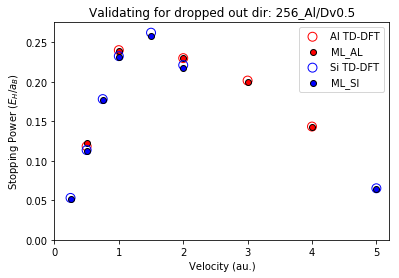

Epoch 1/50
81065/81065 [==============================] - 7s 87us/step - loss: 0.1099 - mean_absolute_error: 0.1099
Epoch 2/50
81065/81065 [==============================] - 7s 89us/step - loss: 0.0382 - mean_absolute_error: 0.0382
Epoch 3/50
81065/81065 [==============================] - 7s 90us/step - loss: 0.0340 - mean_absolute_error: 0.0340
Epoch 4/50
81065/81065 [==============================] - 7s 86us/step - loss: 0.0297 - mean_absolute_error: 0.0297
Epoch 5/50
81065/81065 [==============================] - 7s 89us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 6/50
81065/81065 [==============================] - 7s 87us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 7/50
81065/81065 [==============================] - 7s 80us/step - loss: 0.0240 - mean_absolute_error: 0.0240
Epoch 8/50
81065/81065 [==============================] - 7s 88us/step - loss: 0.0232 - mean_absolute_error: 0.0232
Epoch 9/50
81065/81065 [==============================] - 6s 80us/step -

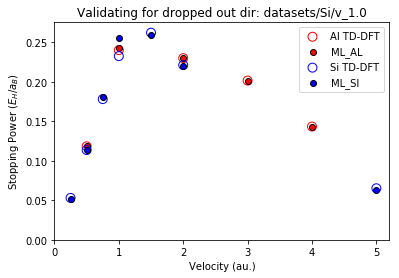

Epoch 1/50
66323/66323 [==============================] - 7s 98us/step - loss: 0.2072 - mean_absolute_error: 0.2072
Epoch 2/50
66323/66323 [==============================] - 6s 88us/step - loss: 0.1645 - mean_absolute_error: 0.1645
Epoch 3/50
66323/66323 [==============================] - 6s 85us/step - loss: 0.1219 - mean_absolute_error: 0.1219
Epoch 4/50
66323/66323 [==============================] - 6s 84us/step - loss: 0.0444 - mean_absolute_error: 0.0444
Epoch 5/50
66323/66323 [==============================] - 6s 90us/step - loss: 0.0375 - mean_absolute_error: 0.0375
Epoch 6/50
66323/66323 [==============================] - 6s 89us/step - loss: 0.0365 - mean_absolute_error: 0.0365
Epoch 7/50
66323/66323 [==============================] - 6s 90us/step - loss: 0.0347 - mean_absolute_error: 0.0347
Epoch 8/50
66323/66323 [==============================] - 6s 89us/step - loss: 0.0333 - mean_absolute_error: 0.0333
Epoch 9/50
66323/66323 [==============================] - 6s 88us/step -

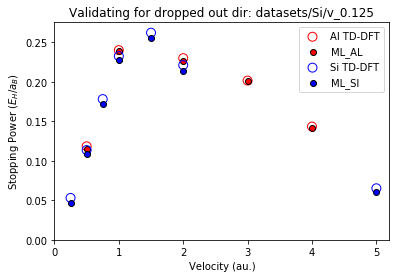

Epoch 1/50
75257/75257 [==============================] - 7s 99us/step - loss: 0.0756 - mean_absolute_error: 0.0756
Epoch 2/50
75257/75257 [==============================] - 6s 84us/step - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 3/50
75257/75257 [==============================] - 7s 88us/step - loss: 0.0315 - mean_absolute_error: 0.0315
Epoch 4/50
75257/75257 [==============================] - 6s 86us/step - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 5/50
75257/75257 [==============================] - 7s 90us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 6/50
75257/75257 [==============================] - 7s 90us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 7/50
75257/75257 [==============================] - 7s 91us/step - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 8/50
75257/75257 [==============================] - 6s 86us/step - loss: 0.0246 - mean_absolute_error: 0.0246
Epoch 9/50
75257/75257 [==============================] - 6s 84us/step -

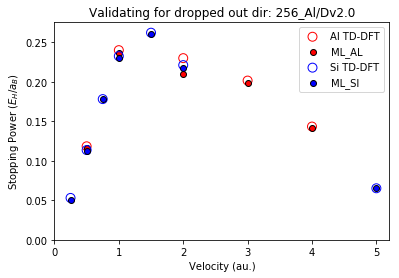

Epoch 1/50
82118/82118 [==============================] - 8s 94us/step - loss: 0.1710 - mean_absolute_error: 0.1710
Epoch 2/50
82118/82118 [==============================] - 7s 89us/step - loss: 0.0970 - mean_absolute_error: 0.0970
Epoch 3/50
82118/82118 [==============================] - 7s 90us/step - loss: 0.0365 - mean_absolute_error: 0.0365
Epoch 4/50
82118/82118 [==============================] - 7s 91us/step - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 5/50
82118/82118 [==============================] - 7s 89us/step - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 6/50
82118/82118 [==============================] - 7s 88us/step - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 7/50
82118/82118 [==============================] - 7s 90us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 8/50
82118/82118 [==============================] - 8s 92us/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 9/50
82118/82118 [==============================] - 8s 92us/step -

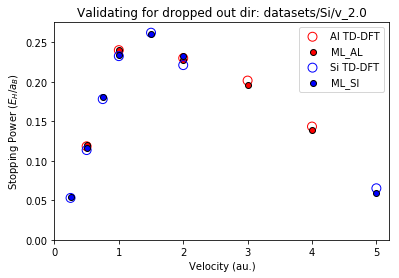

Epoch 1/50
79152/79152 [==============================] - 8s 103us/step - loss: 0.0857 - mean_absolute_error: 0.0857
Epoch 2/50
79152/79152 [==============================] - 7s 83us/step - loss: 0.0376 - mean_absolute_error: 0.0376
Epoch 3/50
79152/79152 [==============================] - 7s 89us/step - loss: 0.0320 - mean_absolute_error: 0.0320
Epoch 4/50
79152/79152 [==============================] - 7s 93us/step - loss: 0.0304 - mean_absolute_error: 0.0304
Epoch 5/50
79152/79152 [==============================] - 8s 96us/step - loss: 0.0301 - mean_absolute_error: 0.0301
Epoch 6/50
79152/79152 [==============================] - 7s 93us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 7/50
79152/79152 [==============================] - 7s 89us/step - loss: 0.0267 - mean_absolute_error: 0.0267
Epoch 8/50
79152/79152 [==============================] - 7s 94us/step - loss: 0.0259 - mean_absolute_error: 0.0259
Epoch 9/50
79152/79152 [==============================] - 7s 94us/step 

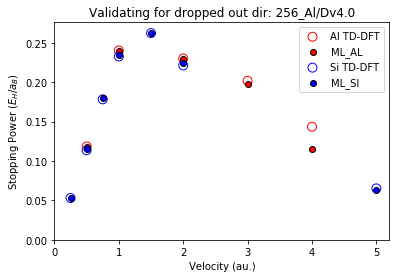

Epoch 1/50
80363/80363 [==============================] - 8s 95us/step - loss: 0.1355 - mean_absolute_error: 0.1355
Epoch 2/50
80363/80363 [==============================] - 7s 89us/step - loss: 0.0348 - mean_absolute_error: 0.0348
Epoch 3/50
80363/80363 [==============================] - 7s 92us/step - loss: 0.0287 - mean_absolute_error: 0.0287
Epoch 4/50
80363/80363 [==============================] - 8s 95us/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 5/50
80363/80363 [==============================] - 7s 92us/step - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 6/50
80363/80363 [==============================] - 7s 89us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 7/50
80363/80363 [==============================] - 7s 90us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 8/50
80363/80363 [==============================] - 8s 95us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 9/50
80363/80363 [==============================] - 7s 91us/step -

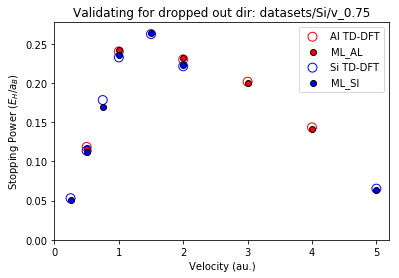

Epoch 1/50
74747/74747 [==============================] - 9s 114us/step - loss: 0.1042 - mean_absolute_error: 0.1042
Epoch 2/50
74747/74747 [==============================] - 7s 93us/step - loss: 0.0454 - mean_absolute_error: 0.0454
Epoch 3/50
74747/74747 [==============================] - 7s 94us/step - loss: 0.0357 - mean_absolute_error: 0.0357
Epoch 4/50
74747/74747 [==============================] - 7s 94us/step - loss: 0.0336 - mean_absolute_error: 0.0336
Epoch 5/50
74747/74747 [==============================] - 7s 93us/step - loss: 0.0319 - mean_absolute_error: 0.0319
Epoch 6/50
74747/74747 [==============================] - 7s 93us/step - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 7/50
74747/74747 [==============================] - 6s 81us/step - loss: 0.0287 - mean_absolute_error: 0.0287
Epoch 8/50
74747/74747 [==============================] - 7s 94us/step - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 9/50
74747/74747 [==============================] - 7s 94us/step 

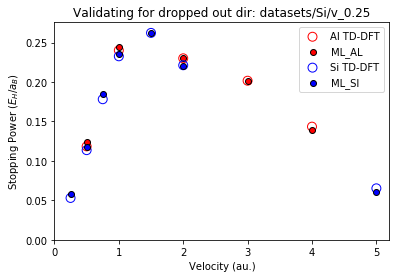

Epoch 1/50
82329/82329 [==============================] - 9s 107us/step - loss: 0.0927 - mean_absolute_error: 0.0927
Epoch 2/50
82329/82329 [==============================] - 8s 93us/step - loss: 0.0366 - mean_absolute_error: 0.0366
Epoch 3/50
82329/82329 [==============================] - 8s 93us/step - loss: 0.0314 - mean_absolute_error: 0.0314
Epoch 4/50
82329/82329 [==============================] - 8s 96us/step - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 5/50
82329/82329 [==============================] - 8s 92us/step - loss: 0.0283 - mean_absolute_error: 0.0283
Epoch 6/50
82329/82329 [==============================] - 8s 95us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 7/50
82329/82329 [==============================] - 7s 90us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 8/50
82329/82329 [==============================] - 7s 90us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 9/50
82329/82329 [==============================] - 8s 97us/step 

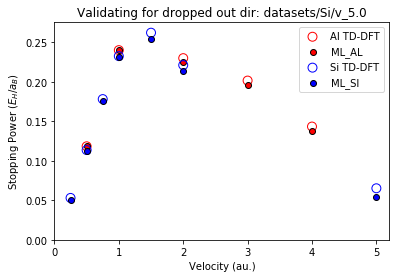

Epoch 1/50
80918/80918 [==============================] - 9s 110us/step - loss: 0.1534 - mean_absolute_error: 0.1534
Epoch 2/50
80918/80918 [==============================] - 7s 90us/step - loss: 0.0497 - mean_absolute_error: 0.0497
Epoch 3/50
80918/80918 [==============================] - 8s 93us/step - loss: 0.0322 - mean_absolute_error: 0.0322
Epoch 4/50
80918/80918 [==============================] - 8s 96us/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 5/50
80918/80918 [==============================] - 8s 96us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 6/50
80918/80918 [==============================] - 7s 93us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 7/50
80918/80918 [==============================] - 8s 94us/step - loss: 0.0242 - mean_absolute_error: 0.0242
Epoch 8/50
80918/80918 [==============================] - 8s 96us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 9/50
80918/80918 [==============================] - 7s 92us/step 

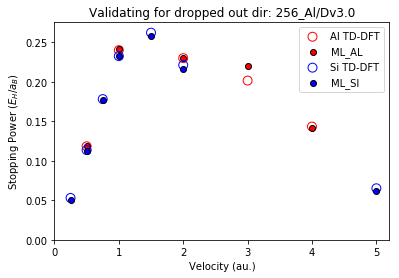

Epoch 1/50
78959/78959 [==============================] - 9s 111us/step - loss: 0.0978 - mean_absolute_error: 0.0978
Epoch 2/50
78959/78959 [==============================] - 7s 93us/step - loss: 0.0394 - mean_absolute_error: 0.0394
Epoch 3/50
78959/78959 [==============================] - 8s 98us/step - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 4/50
78959/78959 [==============================] - 8s 104us/step - loss: 0.0293 - mean_absolute_error: 0.0293
Epoch 5/50
78959/78959 [==============================] - 8s 98us/step - loss: 0.0300 - mean_absolute_error: 0.0300
Epoch 6/50
78959/78959 [==============================] - 8s 103us/step - loss: 0.0279 - mean_absolute_error: 0.0279
Epoch 7/50
78959/78959 [==============================] - 8s 97us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 8/50
78959/78959 [==============================] - 8s 98us/step - loss: 0.0246 - mean_absolute_error: 0.0246
Epoch 9/50
78959/78959 [==============================] - 7s 95us/ste

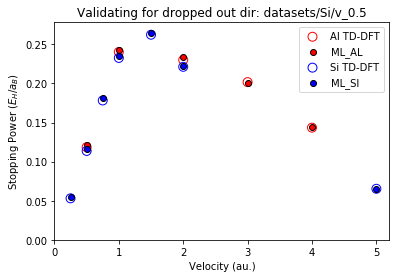

Epoch 1/50
73667/73667 [==============================] - 8s 112us/step - loss: 0.1361 - mean_absolute_error: 0.1361
Epoch 2/50
73667/73667 [==============================] - 7s 98us/step - loss: 0.1058 - mean_absolute_error: 0.1058
Epoch 3/50
73667/73667 [==============================] - 7s 96us/step - loss: 0.1010 - mean_absolute_error: 0.1010
Epoch 4/50
73667/73667 [==============================] - 7s 98us/step - loss: 0.0981 - mean_absolute_error: 0.0981
Epoch 5/50
73667/73667 [==============================] - 7s 96us/step - loss: 0.0944 - mean_absolute_error: 0.0944
Epoch 6/50
73667/73667 [==============================] - 7s 98us/step - loss: 0.0924 - mean_absolute_error: 0.0924
Epoch 7/50
73667/73667 [==============================] - 7s 96us/step - loss: 0.0920 - mean_absolute_error: 0.0920
Epoch 8/50
73667/73667 [==============================] - 7s 94us/step - loss: 0.0907 - mean_absolute_error: 0.0907
Epoch 9/50
73667/73667 [==============================] - 7s 101us/step

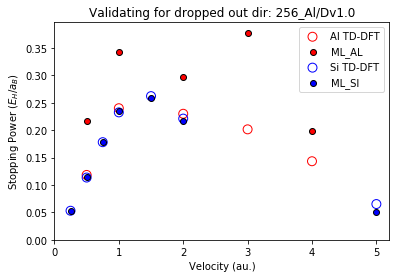

Epoch 1/50
81767/81767 [==============================] - 10s 125us/step - loss: 0.1566 - mean_absolute_error: 0.1566
Epoch 2/50
81767/81767 [==============================] - 8s 99us/step - loss: 0.0530 - mean_absolute_error: 0.0530
Epoch 3/50
81767/81767 [==============================] - 8s 97us/step - loss: 0.0315 - mean_absolute_error: 0.0315
Epoch 4/50
81767/81767 [==============================] - 8s 99us/step - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 5/50
81767/81767 [==============================] - 8s 97us/step - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 6/50
81767/81767 [==============================] - 7s 90us/step - loss: 0.0256 - mean_absolute_error: 0.0256
Epoch 7/50
81767/81767 [==============================] - 8s 97us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 8/50
81767/81767 [==============================] - 7s 87us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 9/50
81767/81767 [==============================] - 8s 100us/ste

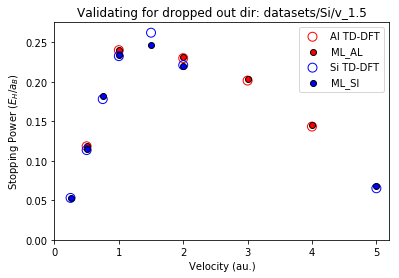

In [36]:
input_shape = (len(X_cols),)
layers = (input_shape[0],18,16,12,8,4)
activation = 'selu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 50
#i = 0



for i in range(len(train_sets)):
    callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=3, verbose=1, factor=0.5, mode='auto'),
            EarlyStopping(monitor='mean_absolute_error', patience=6, verbose=0, mode='auto')]
    
    fit_and_cross_test( build_dense_model(layers, input_shape, activation), train_sets[i], test_sets[i],
                   callbacks=callbacks, epochs=epochs, verbose=1)